# Incialização

Será necessário instalar o pacote ```peakutils```. Isto pode ser feito no terminal de comando do seu sistema operacional: ```pip install peakutils```. Caso você esteja usando o _PineApple_ (Mac ou Linux), é possível fazer de dentro do Jupyter utilizando (após ```import pineapple```) ```%pip install peakutils```

<IPython.core.display.Javascript object>


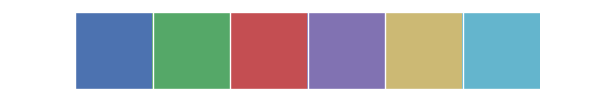

In [1]:
#Importa pacotes relevantes
import matplotlib.pyplot as plt #pacote para graficar a la matlab
import numpy as np #pacote de calculo numerico, a la matlab
import pandas as pd
import os
import peakutils
%matplotlib notebook
#PACOTE PARA CORES MAIS ELEGANTES NOS GRÁFICOS
import seaborn as sns
current_palette = sns.color_palette()
sns.palplot(current_palette)
sns.set(style="whitegrid")
#-----------------
#Ajsutando fontes padrão dos gráficos
#%matplotlib inline
font = { 'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)
#-----------------

# 1) Calibração com laser HeNe

## a) Carregando os dados

In [2]:
print('Pasta atual:',os.getcwd())
path='/Users/gsw/Dropbox/Disciplinas/f429/2017_1s/python/michelson'
file_name='exp_michelson_mec012_Laser_dados_10_04_42.dat'
full_path_He=os.path.join(path,file_name)

#formatting PANDAS output
pd.options.display.float_format = '{:20,.2e}'.format
#carregando arquivo
dfHe = pd.read_csv(full_path_He,sep='\t')
# Remove o primeiro ponto que possui valor nulo
dfHe.drop(0,inplace=True) 
dfHe.head()
tempo = dfHe['Tempo'].values
lum = dfHe['Luminosidade'].values

Pasta atual: /Users/gsw/github/F429_notas/Michelson


## Grafico dos dados brutos 

<IPython.core.display.Javascript object>


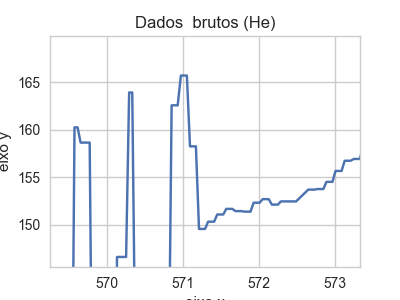

In [3]:
plt.figure(figsize=(4,3))
plt.plot(tempo,lum,'-')
plt.xlabel('eixo x')
plt.ylabel('eixo y')
plt.title('Dados  brutos (He)')
plt.show()

<span style=color:red>__ Observação__: Note que os dados estão centrados em torno de um valor médio, diferente de zero! Para facilitar o tratamento é interessante deslocar os dados.

Para tanto vamos calcular o valor médio da luminosidade utilizando o método ```.mean()```:
</span>

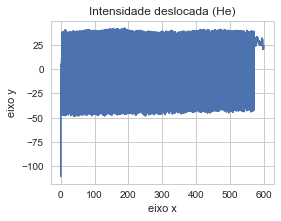

In [4]:
valor_medio = np.mean(lum) # valor médio da intensidade luminosa
lum_s = lum-valor_medio
#---------
plt.figure(figsize=(4,3))
plt.plot(tempo,lum_s,'-')
plt.xlabel('eixo x')
plt.ylabel('eixo y')
plt.title('Intensidade deslocada (He)')
plt.show()

<span style=color:red> Para associar o eixo de tempo com o deslocamento do motor, é fundamental encontrar os pontos nos quais o motor foi ligado. Isto pode ser feito manualmente, dando um zoom nos gráficos anteriores.

__Note que é necessário você adaptar os limites do gráfico usando o método ```.xlim()``` para contemplar os seus dados. Faça isto iterativamente, começando com um zoom grosseiro e depois refinando; um chute para os valores pode se basear nos valores da escala horizontal do gráfico anterior__
</span>

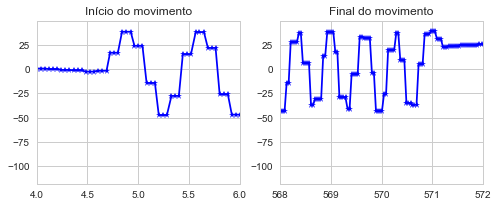

In [5]:
fig, ax = plt.subplots(2,figsize=(8,3))
#----
#inicio
plt.subplot(121)
plt.plot(tempo,lum_s,'-*b')
plt.xlim([4, 6])
plt.title('Início do movimento')
#-----
#fim
plt.subplot(122)
plt.plot(tempo,lum_s,'-*b')
plt.xlim([568, 572])
plt.title('Final do movimento')
plt.show()

No caso dos dados mostrados, vemos que:

a) o instante de tempo no qual o motor foi ligado foi ```t=4.7 s```

b) o instante de tempo no qual o motor foi ligado foi ```t=571.2 s```

Portanto devemos encontrar os índices do vetor de tempos que corresponde a estes valores – o que nos permitirá "recortar" os dados apenas nesta região. Para encontrar os índices, usamos o comando ```where``` do Numpy:

In [6]:
#encontrando os índices:
t0=4.7
indices = np.where( tempo>t0 )[0]
ind_0 = indices[0]
print('indice inicial (motor ligando):', ind_0 )
#encontrando os índices:
t0=571.2
indices = np.where( tempo>t0 )[0]
ind_f = indices[0]
print('indice final (motor desligando):', ind_f )

indice inicial (motor ligando): 117
indice final (motor desligando): 14229


Agora vamos recortar a matriz de dados e descartar as partes nas quais o motor será ligado/desligado:

Será necessário fazer diversas manipulações a seguir, para facilitar a sintaxe, vamos criar dois "vetores" de dados associados aos eixos de tempo (```tempo```) e luminosidade (```lum```):

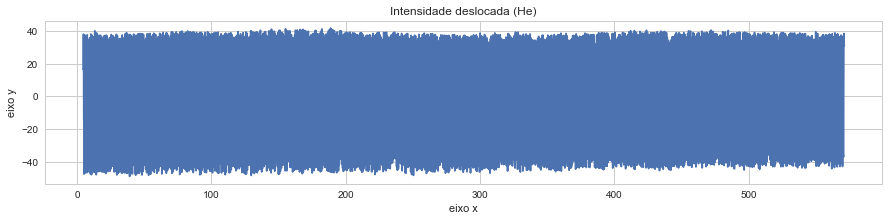

In [7]:
tempo_c = tempo[ind_0:ind_f]
lum_c = lum_s[ind_0:ind_f]
#---------
#graficando
plt.figure(figsize=(15,3))
plt.plot(tempo_c, lum_c,'-')
plt.xlabel('eixo x')
plt.ylabel('eixo y')
plt.title('Intensidade deslocada (He)')
plt.show()

__Note que no gráfico acima, não existem mais as regiões nas quais o motor ainda estava desligado!__

### Encontrado o número de franjas:

Usaremos a seguinte estratégia: cada ciclo de oscilação, entre dois máximos consecutivos, a função passa duas vezes pelo zero. 

Para acharmos o zero, 

a) vamos calcular o sinal de cada elemento do vetor com a função ```np.sign()``` e armazenar no vetor ```sign```

b) calculando a diferença consecutiva do vetor ```sign``` com a função ```np.diff()```, armazenamos no vetor ```pos``` valores booleanos indicando quando o resultado de ```np.difff()``` é diferente de zero (ou seja, o vetor mudou de sinal naquele elemento)

c) encontramos os índices nos quais o vetor ```pos``` é booleano verdadeiro usando a função ```np.where()```

d) Como o vetor passa pelo zero duas vezes, entre dois máximos consecutivos, extramos um a cada dois elementos do vetor

In [8]:
sign = np.sign(lum_c) #sinal
pos = np.diff(sign) != 0 #quando o sinal muda
indice0 = np.where(pos)[0] #indices
indice0 = indice0[0::2] # pega os elementos 0,2,4,6... até o último
n_franjas = np.size(indice0)
#intervalo de tempo para cada franja
delta_t = np.diff(tempo_c[indice0])
delta_t_medio = delta_t.mean()
delta_t_sigma = delta_t.std()
#--------------------------
n_franjas = np.size(indice0) # numero de franjas
tempo_total = tempo[ind_f]-tempo[ind_0] # tempo de aquisição
print('intervalo médio de tempo entre duas franjas = {:2g} s'.format( delta_t_medio ))
print('desvio padrão de tempo entre duas franjas = {:2g} s'.format( delta_t_sigma ))
print('número de franjas = {:2g}'.format(n_franjas))
print('velocidade = {:2.5g} franjas/s'.format(n_franjas/tempo_total))

intervalo médio de tempo entre duas franjas = 0.673904 s
desvio padrão de tempo entre duas franjas = 0.0749897 s
número de franjas = 840
velocidade = 1.4828 franjas/s


Agora façamos alguns gráficos ilustrando os resultados acima, é importante para validar e garantir que identificamos corretamente cada franja

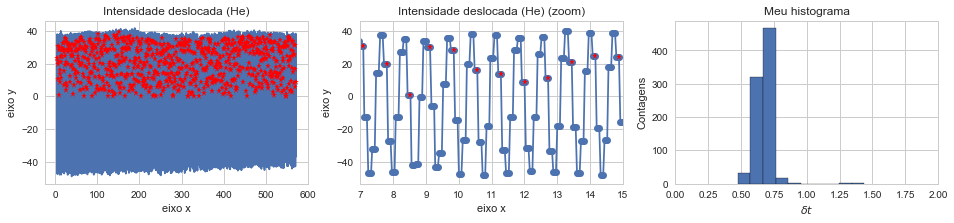

In [9]:
#----
fig, ax = plt.subplots(3,figsize=(16,3))
#----
#inicio
plt.subplot(131)

plt.plot(tempo_c, lum_c,'-')
plt.plot(tempo_c[indice0],lum_c[indice0],'*r')
plt.xlabel('eixo x')
plt.ylabel('eixo y')
plt.title('Intensidade deslocada (He)')
#------- zoom
plt.subplot(132)
plt.plot(tempo_c, lum_c,'-o')
plt.plot(tempo_c[indice0],lum_c[indice0],'*r')
plt.xlabel('eixo x')
plt.ylabel('eixo y')
plt.title('Intensidade deslocada (He) (zoom)')
plt.xlim([7,15])
#------ histograma da distancia temporal entre franjas
plt.subplot(133)
plt.hist(delta_t,edgecolor=(0,0,0))
plt.xlabel(r'$\delta t$')
plt.ylabel(r'Contagens')
plt.title('Meu histograma')
plt.xlim((0,2))
plt.show()
#salvando figura
fig.savefig('fig_michelson.pdf')

## <span style=color:red> Itens fundamentais para o relatório:  </span>

i) Usar as informações acima (adaptadas para o seus resultados), junto com as medições do curso do parafuso, para obter a razão de redução do interferômetro

ii) Gerar um gráfico das franjas, parecido com o trio de gráficos anterior, porém com o eixo horizontal contendo valores da posição, ao invés de tempo. Escolha a escala par enfatizar $\lambda/2$ entre dois máximos.

iii) Com base na estatística de intervalos de tempo, determine a imprecisão da medida do fator de redução.


In [5]:
file_name='exp_michelson_mec012_Sodio_dados_09_32_09.dat'
full_path_Na=os.path.join(path,file_name)
print(full_path_Na)

/Users/gsw/Dropbox/Disciplinas/f429/2017_1s/python/michelson/exp_michelson_mec012_Sodio_dados_09_32_09.dat


In [6]:
#formatting PANDAS output
pd.options.display.float_format = '{:20,.2e}'.format
#reading excel
dfNa = pd.read_csv(full_path_Na,sep='\t')
#remove o primeiro ponto, geralmente tem o valor nulo
dfNa.drop(0,inplace=True)
tempo = dfNa['Tempo'].values
lum = dfNa['Luminosidade'].values
dfNa.head()

,Tempo,Luminosidade
1,4.30e-02,9.68e+01
2,5.80e-02,8.87e+01
3,8.20e-02,8.87e+01
4,1.22e-01,8.87e+01
5,1.63e-01,8.76e+01


## Grafico dos dados brutos 

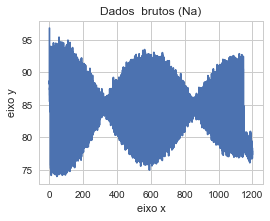

In [7]:
#Você coloca um código que produz a figura abaixo, se baseie no exemplo para o laser de HeNe

<span style=color:red>__ Observação__: Note que os dados estão centrados em torno de um valor médio, diferente de zero! Para facilitar o tratamento é interessante deslocar os dados.

Para tanto vamos calcular o valor médio da luminosidade utilizando o método ```.mean()```:
</span>

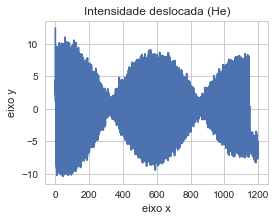

In [8]:
#Você coloca um código que produz a figura abaixo, se baseie no exemplo para o laser de HeNe

<span style=color:red> Para associar o eixo de tempo com o deslocamento do motor, é fundamental encontrar os pontos nos quais o motor foi ligado. Isto pode ser feito manualmente, dando um zoom nos gráficos anteriores.

__Note que é necessário você adaptar os limites do gráfico usando o método ```.xlim()``` para contemplar os seus dados. Faça isto iterativamente, começando com um zoom grosseiro e depois refinando; um chute para os valores pode se basear nos valores da escala horizontal do gráfico anterior__
</span>

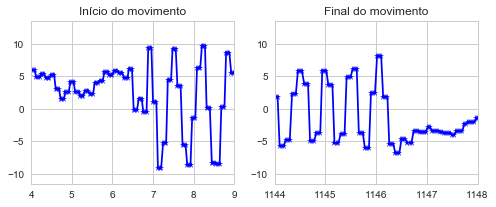

In [17]:
#Você coloca um código que produz a figura abaixo, se baseie no exemplo para o laser de HeNe

No caso dos dados mostrados, vemos que:

a) o instante de tempo no qual o motor foi ligado foi ```t=4.7 s```

b) o instante de tempo no qual o motor foi ligado foi ```t=571.2 s```

Portanto devemos encontrar os índices do vetor de tempos que corresponde a estes valores – o que nos permitirá "recortar" os dados apenas nesta região. Para encontrar os índices, usamos o comando ```where``` do Numpy:

In [19]:
#Você coloca um código que produz os resultados abaixo, se baseie no exemplo para o laser de HeNe

indice inicial (motor ligando): 175
indice final (motor desligando): 28586


Agora vamos recortar a matriz de dados e descartar as partes nas quais o motor será ligado/desligado:

Será necessário fazer diversas manipulações a seguir, para facilitar a sintaxe, vamos criar dois "vetores" de dados associados aos eixos de tempo (```tempo```) e luminosidade (```lum```):

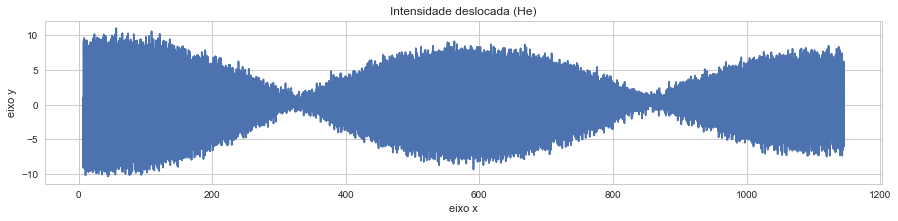

In [20]:
#Você coloca um código que produz a figura abaixo, se baseie no exemplo para o laser de HeNe

__Note que no gráfico acima, não existem mais as regiões nas quais o motor ainda estava desligado!__

### Encontrado o número de franjas:

Usaremos a seguinte estratégia: cada ciclo de oscilação, entre dois máximos consecutivos, a função passa duas vezes pelo zero. 

Para acharmos o zero, 

a) vamos calcular o sinal de cada elemento do vetor com a função ```np.sign()``` e armazenar no vetor ```sign```

b) calculando a diferença consecutiva do vetor ```sign``` com a função ```np.diff()```, armazenamos no vetor ```pos``` valores booleanos indicando quando o resultado de ```np.difff()``` é diferente de zero (ou seja, o vetor mudou de sinal naquele elemento)

c) encontramos os índices nos quais o vetor ```pos``` é booleano verdadeiro usando a função ```np.where()```

d) Como o vetor passa pelo zero duas vezes, entre dois máximos consecutivos, extramos um a cada dois elementos do vetor

In [21]:
#Você coloca um código que produz os resultados abaixo, se baseie no exemplo para o laser de HeNe

intervalo médio de tempo entre duas franjas = 0.545536 s
desvio padrão de tempo entre duas franjas = 0.114625 s
número de franjas = 2088
velocidade = 1.8332 franjas/s


Agora façamos alguns gráficos ilustrando os resultados acima, é importante para validar e garantir que identificamos corretamente cada franja

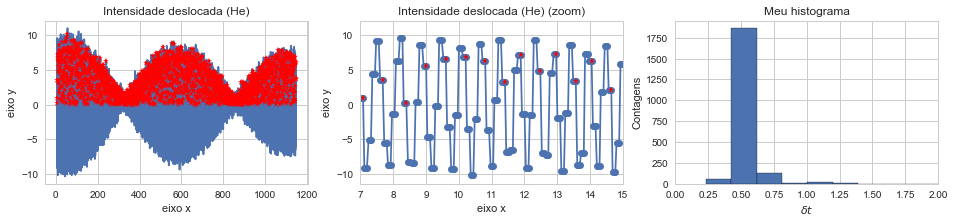

In [22]:
#Você coloca um código que produz a figura abaixo, se baseie no exemplo para o laser de HeNe

Encontrando as envoltórias:

a) Vamos calcular o quadrado da função (já deslocada em torno do zero), encontrar o envelope utilizando a função peakutils.envelope(), note que nesta função você talvez precise ajustar o grau do polinômio (```deg```). O importante é que você obtenha um envelope fiel ao seus dados.

b) Para encontrar a posição dos picos, você pode fazer manualmente (dando zoom no gráfico), ou utilizar a função ```peakutils.indexes()``` para encontrar picos

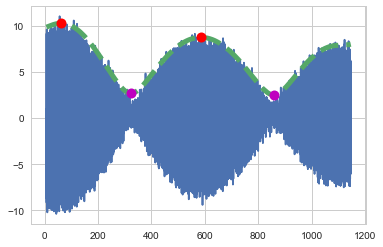

In [24]:
env = np.sqrt(peakutils.envelope(lum_c**2,deg=10))
#encontrando os picos do envelope:
limiar = 0.1 #VOCÊ DEVE ALTERAR ESTE VALOR PARA ENCONTRAR OS PICOS NOS SEUS DADOS
indice0_max = peakutils.indexes( env, thres=limiar/max(env), min_dist=100) #  maximos
indice0_min = peakutils.indexes( -env, thres=limiar/max(env), min_dist=100) # minimos
#---
plt.plot(tempo_c, lum_c,'-')
plt.plot(tempo_c,env,'--',linewidth=5)
plt.plot(tempo_c[indice0_max],env[indice0_max],'or',markersize=10)
plt.plot(tempo_c[indice0_min],env[indice0_min],'om',markersize=10)
plt.show()

A diferença de tempo entre dois máximos, ou dois mínimos, pode ser obtida:

In [26]:
delta_max = tempo_c[indice0_max]
delta_min = tempo_c[indice0_min]
print('instantes de tempo dos máximos: ', delta_max)
print('instantes de tempo dos mínimos: ', delta_min)

instantes de tempo dos máximos:  [  62.0495491   585.13546777]
instantes de tempo dos mínimos:  [ 323.54950619  857.31403565]


O intervalo de tempo entre dois máximos ou dois mínimos pode ser calculada:

In [27]:
dt_max = np.diff(delta_max)
dt_min = np.diff(delta_min)
dt_medio = (dt_min+dt_max)/2
print('diferença dos máximos: ', dt_max)
print('diferença dos mínimos: ', dt_min)
print('valor médio: ', dt_medio)

diferença dos máximos:  [ 523.08591866]
diferença dos mínimos:  [ 533.76452947]
valor médio:  [ 528.42522407]


## <span style=color:red> Itens fundamentais para o relatório:  </span>

i) Usar as informações acima (adaptadas para o seus resultados), junto com as medições do curso do parafuso, para obter o comprimento de onda médio $\bar{\lambda}$ do dubleto de sódio.

ii) Gerar um gráfico das franjas, parecido com o trio de gráficos gerados para o laser de HeNe, porém com o eixo horizontal contendo valores da posição, ao invés de tempo. Escolha a escala par enfatizar $\lambda/2$ entre dois máximos.

iii) Mostrar gráfico com eixo horizontal em escala de distância, com a posição dos mínimos destacada

iv) Com base na estatística de intervalos de tempo, determine a imprecisão na medida do dubleto. Propague as incertezas envolvidas.

v) Determine a separação espectral $\delta\lambda$ do dubleto do sódio.
